# Recommend top restaurants based on consumer preference using popularity and collaborative recommender systems

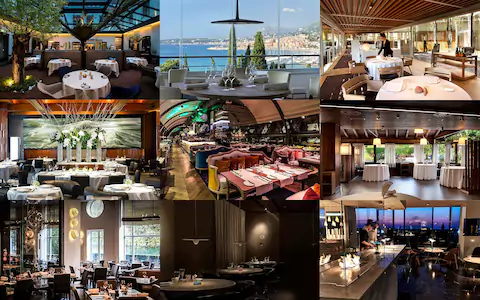

Recommender/recommendation system is a subclass of information filtering system that seeks to predict the rating/ preference a user would give to an item.

They are primarily used in applications where a person/ entity is involved with a product/ service. To further improve their experience with this product, we try to personalize it to their needs. For this we have to look up at their past interactions with this product.

In one line -> **Specialized content for everyone.**

For further info, [Wiki](https://en.wikipedia.org/wiki/Recommender_system)

**Types of Recommender System**

* 1). [Popularity Based](https://www.kaggle.com/sasha18/popularity-based-movie-recommendation)
* 2). Classification Based
* 3). [Content Based](https://www.kaggle.com/sasha18/recommend-books-using-count-tfidf-on-titles)
* 4). Collaborative Based
* 5). [Hybrid Based (Content + Collaborative)](https://www.kaggle.com/sasha18/recommend-top-restaurants-based-on-preference)
* 6). [Association Based Rule Mining](https://www.kaggle.com/sasha18/perform-market-basket-analysis-with-e-comm-data)

We use 'rating_final' dataset to recommend restaurants based on popularity & based on Collaborative that is the ratings given by other users.

# Import packages and dataset

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #this helps to full output and not only the last lines of putput

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.sparse

import warnings
warnings.simplefilter('ignore')

In [ ]:
data = pd.read_csv('../input/restaurant-data-with-consumer-ratings/rating_final.csv')
data.head()

In [ ]:
data.info()

In [ ]:
#Summary statistics
data.describe(include = 'all').transpose()

# Exploratory Data Analytics

To understand the dataset in detail, its important to perform EDA.

**Let's answer few questions:**
* No.of unique users, unique restaurants, no. of ratings, food_ratings, service_ratings
* How many times has a user rated
* How many times has a restaurant been rated
* What's the rating distribution for food, service

In [ ]:
#No.of unique users, restaurants, no. of ratings, food_ratings, service_ratings
print('Unique users: ', data['userID'].nunique())
print('Unique restaurant: ', data['placeID'].nunique())
print('Total no.of ratings given: ', data['rating'].count())
print('Total no.of food ratings given: ', data['food_rating'].count())
print('Total no.of service ratings given: ', data['service_rating'].count())

In [ ]:
# How many times has a user rated
most_rated_users = data['userID'].value_counts()
most_rated_users

In [ ]:
#How many times has a restaurant been rated
most_rated_restaurants = data['placeID'].value_counts()
most_rated_restaurants

In [ ]:
#What's the rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['rating'])

In [ ]:
#What's the food rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['food_rating'])

In [ ]:
#What's the service rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['service_rating'])

**With this EDA, we can infer:**
* All 130 restaurants were rated minimum 3 times on a scale of 0 to 2
* All 138 users have rated minimum 3 times
* As for the rating distribution, users were quite satisfied with restaurants as significant no. of users have rated 1,2

Total no. of ratings were 1161, however if each of the user would have rated all the restaurants it would have been a total of 138 * 130 = 17940 ratings

**For a recommendation system model to recommend top prefered restaurants, we need to have each of the users rating all the restaurants. As this is not possible, we have to predict ratings that a user would give to a restaurant.**

**Let's build a dataset containing users who have actively rated atleast n times.**

In [ ]:
#How many users have rated more than n places ?
n = 3
user_counts = most_rated_users[most_rated_users > n]
len(user_counts)
user_counts

In [ ]:
#No. of ratings given
user_counts.sum()

In [ ]:
#Retrieve all ratings given by the above users from the full data
data_final = data[data['userID'].isin(user_counts.index)]
data_final

In [ ]:
final_ratings_matrix = data_final.pivot(index = 'userID', columns = 'placeID', values = 'rating').fillna(0)
final_ratings_matrix.head()

In [ ]:
#Lets calculate the density of the matrix. This is to see how many possible ratings could be given and exactly how many ratings were given 

#No. of ratings given
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings: ', given_num_of_ratings)

#Total no. of ratings that could have been given 
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings: ', possible_num_of_ratings)

#Calculate matrix density
density = (given_num_of_ratings / possible_num_of_ratings) * 100
print('density: {:4.2f}%'.format(density))

Many ratings are 0 so we are not sure if they are really 0 or users haven't rated them.

# Popularity based Recommender Model

As the name suggests it recommends based on what is currently trending/ popular across the site. This is particularly useful when you don't have past data as a reference to recommend product to the user. It is not tailor fit for any particular group of audience or movie.

*For a better understanding you can refer to kernel -> [Popularity based Movie Recommender](https://www.kaggle.com/sasha18/popularity-based-movie-recommendation)*

**Things to do:**
* No. of users who have rated a resto
* Rank them based on scores
* Recommend most popular places

In [ ]:
#No. of users who have rated a resto
data_grouped = data.groupby('placeID').agg({'userID':'count'}).reset_index()
data_grouped.rename(columns = {'userID': 'score'}, inplace = True )
data_sort = data_grouped.sort_values(['score','placeID'], ascending = False)
data_sort.head()

In [ ]:
#Let's rank them based on scores
data_sort['Rank'] = data_sort['score'].rank(ascending = 0, method = 'first')
pop_recom = data_sort
pop_recom.head()

In [ ]:
print('Here are the most popular restaurants')
pop_recom[['placeID','score','Rank']].head()

**As this is a popularity based recommendation, it is not personalized hence the recommendation remain the same for all the users.**

# Collaborative filtering model

Using Model based Collaborative filtering: Singular Value Decomposition

**Things to do:**
* Transform the data into a pivot table -> Format required for colab model
* Create a user_index column to count the no. of users -> Change naming convention of user by using counter
* Apply SVD method on a large sparse matrix -> To predict ratings for all resto that weren't rated by a user
* Predict ratings for all restaurants not rated by a user using SVD
* Wrap it all into a function

In [ ]:
#Transform the data into a pivot table -> Format required for colab model
pivot_data = data_final.pivot(index = 'userID', columns = 'placeID', values = 'rating').fillna(0)
pivot_data.shape
pivot_data.head()

In [ ]:
#Create a user_index column to count the no. of users -> Change naming convention of user by using counter
pivot_data['user_index'] = np.arange(0, pivot_data.shape[0],1)
pivot_data.head()

In [ ]:
pivot_data.set_index(['user_index'], inplace = True)
pivot_data.head()

In [ ]:
#Applying SVD method on a large sparse matrix -> To predict ratings for all resto that weren't rated by a user

from scipy.sparse.linalg import svds

#SVD
U,s, VT = svds(pivot_data, k = 10)

#Construct diagonal array in SVD
sigma = np.diag(s)

#Applying SVD would output 3 parameters namely
print("U = ",U) #Orthogonal matrix
print('************************************************')
print("S = ",s) #Singular values
print('************************************************')
print("VT = ", VT) #Transpose of Orthogonal matrix

**Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition. SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining**

In [ ]:
#Predict ratings for all restaurants not rated by a user using SVD
all_user_predicted_ratings = np.dot(np.dot(U,sigma), VT)

#Predicted ratings
pred_data = pd.DataFrame(all_user_predicted_ratings, columns = pivot_data.columns)
pred_data.head()

**Wrapping into all into a function**

**Things to do**
* Create a function to recommend places with highest predicted ratings
* Use the function to recommend places based on userID, past ratings, predicted ratings, num of places 

In [ ]:
#Recommend places with the highest predicted ratings

def recommend_places(userID, pivot_data, pred_data, num_recommendations):
    user_index  = userID-1 #index starts at 0

    sorted_user_ratings = pivot_data.iloc[user_index].sort_values(ascending = False) #sort user ratings

    sorted_user_predictions = pred_data.iloc[user_index].sort_values(ascending = False)#sorted_user_predictions
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Places'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\n Below are the recommended places for user(user_id = {}):\n'. format(userID))
    print(temp.head(num_recommendations))

In [ ]:
#Recommend places based on userID, past ratings, predicted ratings, num of places 

userID = 12
num_recommedations = 5
recommend_places(userID, pivot_data, pred_data, num_recommedations)

# Evaluate model using RMSE

RMSE is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSE. Consequently, RMSE is sensitive to outliers.

***For more info -> [Wiki](https://en.wikipedia.org/wiki/Root-mean-square_deviation)***

**Things to do:**
* Actual ratings given by user
* Predicted ratings for a place
* Calculate RMSE

In [ ]:
#Actual ratings given by the users
final_ratings_matrix.head()

#Average actual rating for each place

final_ratings_matrix.mean().head()

In [ ]:
#Predicted ratings for a place
pred_data.head()

#Average predicted rating for each place
pred_data.mean().head()

In [ ]:
#Calculate RMSE

rmse_data = pd.concat([final_ratings_matrix.mean(), pred_data.mean()], axis = 1)
rmse_data.columns = ['Avg_actual_ratings','Avg_predicted_ratings']
print(rmse_data.shape)
rmse_data['place_index'] = np.arange(0, rmse_data.shape[0],1)
rmse_data.head()

In [ ]:
RMSE = round((((rmse_data.Avg_actual_ratings - rmse_data.Avg_predicted_ratings) ** 2).mean() ** 0.5),5)
print('\n RMSE SVD Model = {}\n'.format(RMSE))

**Summarise your insights.**

Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may not be suitable to the user. Popularity based model will recommend the same 5 places to all users but Collaborative Filtering based model has recommended entire different list based on the user ratings.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior/ interaction of the user and it is not dependent on any additional information. In this case we had ratings which showed interaction.